In [ ]:
pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from torch.autograd import Variable
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import LayerConductance

In [ ]:

# Load VGG16 model
model = models.vgg16(pretrained=True)
model.eval()

# Preprocess the input image
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(image_path)
    img_tensor = preprocess(img).unsqueeze(0)
    return img_tensor
# Load and preprocess the image
image_path = '/content/squirrel.JPEG'  # Replace with your image path
input_image = preprocess_image(image_path)

## 1- Conductance distribution

Neuron Importances
0 :  0.0200
1 :  0.0112
2 :  0.0754
3 :  0.0055
4 :  0.0036
5 :  0.0028
6 :  0.0296
7 :  0.0084
8 :  0.0211
9 :  0.0124
10 :  0.0000
11 :  0.0153
12 :  0.0718
13 :  0.0809
14 :  0.0000
15 :  0.0336
16 :  0.0117
17 :  0.0075
18 :  0.0248
19 :  0.0136
20 :  0.0175
21 :  0.0009
22 :  0.0057
23 :  0.0233
24 :  0.0126
25 :  0.0000
26 :  0.0001
27 :  0.0333
28 :  0.0866
29 :  0.0249
30 :  0.0030
31 :  0.0127
32 :  0.0073
33 :  0.0123
34 :  0.0000
35 :  0.0120
36 :  0.0000
37 :  0.0386
38 :  0.0118
39 :  0.0110
40 :  0.0000
41 :  0.0276
42 :  0.0084
43 :  0.0034
44 :  0.0043
45 :  0.0032
46 :  0.0137
47 :  0.0076
48 :  0.0157
49 :  0.0378
50 :  0.0426
51 :  0.0019
52 :  0.0022
53 :  0.0384
54 :  0.0056
55 :  0.0036
56 :  0.0167
57 :  0.0079
58 :  0.0113
59 :  0.0114
60 :  0.0899
61 :  0.0000
62 :  0.0234
63 :  0.0068
64 :  0.0333
65 :  0.0543
66 :  0.1017
67 :  0.0042
68 :  0.0050
69 :  0.0052
70 :  0.0051
71 :  0.0019
72 :  0.0739
73 :  0.0000
74 :  0.0245
75 :  0.0090
76 

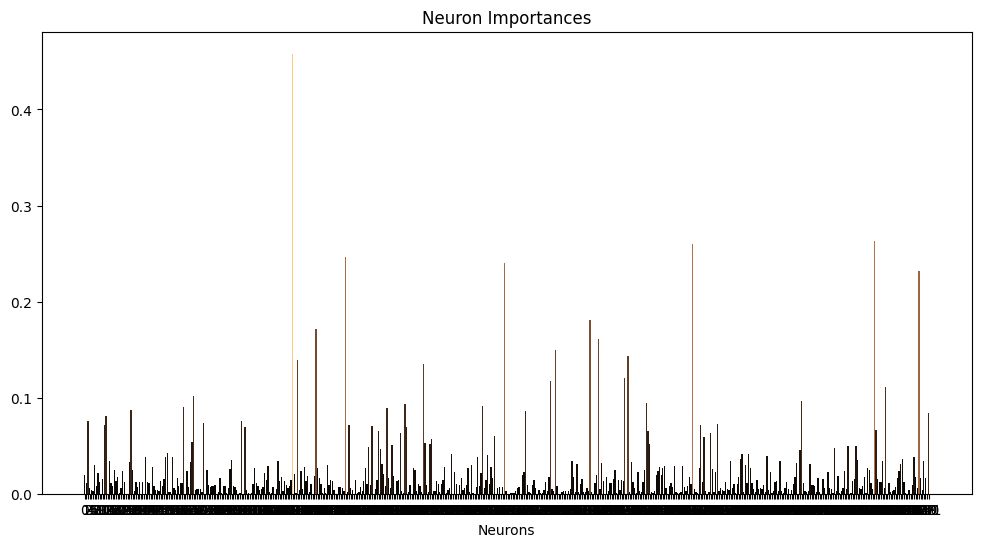

In [ ]:
layer=model.features[29]  #correspond to the last convolutional layer in VGG16
cond =LayerConductance(model,layer)
cond_vals = cond.attribute(input_image,target=37)
cond_vals = cond_vals.detach().numpy()
p=cond_vals.shape[1]
q=cond_vals.shape[2]*cond_vals.shape[3]
cond_vals_flatten_conv=cond_vals.reshape((p,q))


# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.4f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        cmap = plt.get_cmap('copper')
        norm = plt.Normalize(importances.min(), importances.max())
        colors = cmap(norm(importances))
        plt.bar(x_pos, importances, align='center',color=colors)
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)

#plot conductance distribution at layer 13
visualize_importances(range(p),np.max(cond_vals_flatten_conv, axis=1),title="Neuron Importances", axis_title="Neurons")

In [ ]:
importances=np.max(cond_vals_flatten_conv, axis=1)
top_10_indices = np.argsort(importances)[-10:]
top_10_values = importances[top_10_indices]
print(top_10_indices)

In [ ]:
importances=np.max(cond_vals_flatten_conv, axis=1)
np.argmax(importances)

126

## 2- Gradient Ascent using Layer Conductance

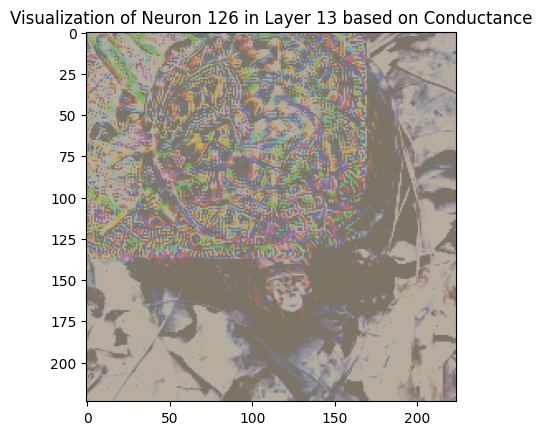

In [ ]:


# Get the specific layer in VGG16 for which you want to calculate conductance
layer_conv = model.features[29]  # Replace with the specific layer you want

# Initialize LayerConductance
cond = LayerConductance(model, layer_conv)

# Calculate conductance for the given input and target
target_class_index = 37  # Replace with your target class index
cond_vals = cond.attribute(input_image, target=target_class_index)
cond_vals = cond_vals.detach().numpy()

# Select the conductance for a specific neuron (filter)
neuron_idx = 126  # Replace with your neuron index, e.g., 0 for the first filter
selected_conductance = cond_vals[:, neuron_idx, :, :]

# Perform Gradient Ascent to visualize the effect of changing the conductance
def visualize_conductance(model, layer_idx, neuron_idx, selected_conductance, iterations=50, lr=0.1):
    input_var = Variable(input_image.clone(), requires_grad=True)
    optimizer = torch.optim.Adam([input_var], lr=lr)

    for i in range(iterations):
        optimizer.zero_grad()

        # Forward pass to get the activation of the target neuron
        cond_vals = cond.attribute(input_var, target=target_class_index)

        # Get the specific conductance value
        cond_value = cond_vals[0, neuron_idx].max()

        # We maximize the conductance
        loss = -cond_value
        loss.backward()

        optimizer.step()

    # Convert tensor to image
    result = input_var.detach().cpu().numpy()[0]
    result = np.transpose(result, (1, 2, 0))
    result = np.clip(result, 0, 1)  # Clip to valid range
    result = (result * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))  # Un-normalize
    result = np.clip(result, 0, 1)

    return result

# Visualize the effect
modified_image = visualize_conductance(model, layer_conv, neuron_idx, selected_conductance, iterations=50, lr=0.1)

plt.imshow(modified_image)
plt.title(f'Visualization of Neuron {neuron_idx} in Layer 13 based on Conductance')
plt.show()


In [ ]:
importances=np.max(cond_vals_flatten_conv, axis=1)
top_10_indices = np.argsort(importances)[-10:]
top_10_values = importances[top_10_indices]
print(top_10_indices)

[199 294 389  73 458 239 485 147 279 385]


In [ ]:
importances=np.max(cond_vals_flatten_conv, axis=1)
np.argmax(importances)

385

## 3- The Gradient Effect

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# Load the VGG16 model
model = models.vgg16(pretrained=True)

# Set the model to evaluation mode
model.eval()

# Choose the layer and filter index
layer_index = 29
filter_index = 418

# Define a hook to capture the activations
activations = None

def forward_hook(module, input, output):
    global activations
    activations = output

# Register the hook to capture activations at the chosen layer
hook = model.features[layer_index].register_forward_hook(forward_hook)

# Pass the input image through the model (make sure the input_image is preprocessed accordingly)
input_image = input_image.requires_grad_(True)
output = model(input_image)

# Remove the hook after the forward pass
hook.remove()

# We now have the activations, let's get the specific filter's activations
filter_activation = activations[:, filter_index, :, :]

# We will compute the gradient with respect to the maximum value in the filter's activation map
max_activation = torch.max(filter_activation)

# Perform backward pass to get the gradient
model.zero_grad()
max_activation.backward()

# The gradient vector for the input image
gradient_vector = input_image.grad

# If needed, convert the gradient vector to a NumPy array for further processing
gradient_vector_np = gradient_vector.detach().numpy()

print(gradient_vector_np.shape)


(1, 3, 224, 224)


In [ ]:
gradient_vector_np

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]], dtype=float32)

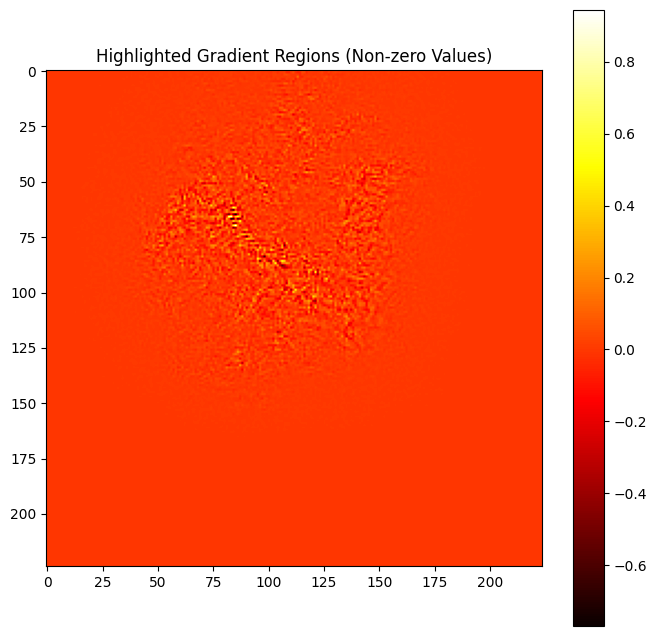

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming gradient_vector is the computed gradient from the previous step
gradient_vector_np = gradient_vector.detach().numpy()

# Create a binary mask where gradients are non-zero
gradient_mask = np.where(gradient_vector_np != 0, 1, 0)

# Apply the mask to the gradient to highlight the regions with non-zero gradients
highlighted_gradient = gradient_vector_np * gradient_mask

# Visualize the highlighted regions by summing across the channels (if you want a 2D representation)
highlighted_gradient_sum = np.sum(highlighted_gradient[0], axis=0)

# Plot the highlighted gradient map
plt.figure(figsize=(8, 8))
plt.imshow(highlighted_gradient_sum, cmap='hot')
plt.colorbar()
plt.title("Highlighted Gradient Regions (Non-zero Values)")
plt.show()
